# LDA
- LDA, or Latent Dirichlet Allocation, is a statistical model used in natural language processing and machine learning for topic modeling. It is a generative probabilistic model that allows you to discover hidden topics in a large corpus of text data.

- The importance of LDA is that it allows you to identify the latent topics within a document or a collection of documents. This can be very useful in a number of applications such as content analysis, sentiment analysis, text classification, and information retrieval.

- The performance of LDA is typically evaluated using a variety of measures, such as perplexity, coherence, and topic diversity. Perplexity measures how well the model can predict new unseen documents, while coherence measures how well the topics generated by the model are interpretable and coherent. Topic diversity measures how different the topics are from each other.

- Interpreting the output of an LDA model involves looking at the most probable words associated with each topic and interpreting them. The topics generated by the model can then be labeled based on these words, and the results can be used to gain insights into the underlying themes in the corpus of text data.

In [1]:
! pip install --quiet --upgrade nltk gensim wordcloud > /dev/null

In [2]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('all', quiet=True)

True

In [3]:
# importing the libraries
import pandas as pd
import pickle
import re
import string
import numpy as np
import gensim
from gensim import corpora
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt
from pprint import pprint
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")


In [4]:
import os

# Identify the working directory and data files
working_directory = "35-LDA_and_NMF_finalized"

# Create the working directory if needed
try:
    os.makedirs(working_directory, exist_ok=True)
except OSError as error:
    print(f"Error creating {working_directory}: {error}")

In [5]:
# loading the data
df = pd.read_pickle("./21-Preprocess-Combined-Data-v2/dataframe.pickle")

In [6]:
# Topics range
min_topics = 1
max_topics = 25

# The number of top words per topic
num_top_words = 10

# Initial random state
random_state = 42

# A row to use for verification of processing
verification_row = 9

In [7]:
df.head()

,ROW_ID,FOI_TEXT,DEVICE_PROBLEM_CODE,DEVICE_PROBLEM_TEXT,GENERIC_NAME,DEVICE_REPORT_PRODUCT_CODE,UDI-DI,UDI-PUBLIC,DATE_OF_EVENT,REPORTER_OCCUPATION_CODE,REPORT_DATE,EVENT_LOCATION,SOURCE_TYPE,TOKENIZED_TEXT,NOPUNCT_TEXT,NOSTOPWORDS_TEXT,NODIGITS_TEXT,POS_TEXT,LEMMATIZED_TEXT,STEMMED_TEXT
0,1969025,IT WAS REPORTED THAT THE TRANSMITTER LOST CONN...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,,,07/30/2020,000,,I,CONSUMER,"[it, was, reported, that, the, transmitter, lo...","[it, was, reported, that, the, transmitter, lo...","[reported, transmitter, lost, connection, pump...","[reported, transmitter, lost, connection, pump...","[(reported, VBN), (transmitter, NN), (lost, VB...","[report, transmitter, lose, connection, pump, ...","[report, transmitt, lost, connect, pump, great..."
1,1426265,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,06/05/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."
2,2609625,IT WAS REPORTED THAT TRANSMITTER FAILED ERROR ...,1435,No Device Output,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/05/2020,000,,I,CONSUMER,"[it, was, reported, that, transmitter, failed,...","[it, was, reported, that, transmitter, failed,...","[reported, transmitter, failed, error, occurre...","[reported, transmitter, failed, error, occurre...","[(reported, VBN), (transmitter, NN), (failed, ...","[report, transmitter, fail, error, occur, data...","[report, transmitt, fail, error, occur, data, ..."
3,2813837,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,10/23/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, revie...","[report, signal, loss, one, hour, occur, revie..."
4,1337517,IT WAS REPORTED THAT SIGNAL LOSS OVER ONE HOUR...,3283,Wireless Communication Problem,CONTINUOUS GLUCOSE MONITOR,QBJ,00386270000385,00386270000385,05/25/2020,000,,I,CONSUMER,"[it, was, reported, that, signal, loss, over, ...","[it, was, reported, that, signal, loss, over, ...","[reported, signal, loss, one, hour, occurred, ...","[reported, signal, loss, one, hour, occurred, ...","[(reported, VBN), (signal, JJ), (loss, NN), (o...","[report, signal, loss, one, hour, occur, produ...","[report, signal, loss, one, hour, occur, produ..."


In [8]:
# create a DataFrame for the sentences
sentences_df = pd.DataFrame(
    columns=[
        'SENTENCE_ID',
        'SENTENCE', 
        'ROW_ID', 
        'FOI_TEXT', 
        'DEVICE_PROBLEM_CODE',
        'DEVICE_PROBLEM_TEXT'
    ]
)

# Iterate over every row in the FOI_TEXT DataFrame
# and create a new dataframe with a row for each sentence.
# Each row will have a sentence, the orginal ROW_ID, and the
# FOI_TEXT that it came from along with the DEVICE_PROBLEM_CODE and
# DEVICE_PROBLEM_TEXT from the orginal FOI_TEXT
sentence_counter = 0

for index, row in df.iterrows():
    for sentence in nltk.sent_tokenize(row['FOI_TEXT']):
        sentence_data = {
            'SENTENCE': sentence,
            'SENTENCE_ID': sentence_counter,
            'ROW_ID': row['ROW_ID'], 
            'FOI_TEXT': row['FOI_TEXT'], 
            'DEVICE_PROBLEM_CODE': row['DEVICE_PROBLEM_CODE'],
            'DEVICE_PROBLEM_TEXT': row['DEVICE_PROBLEM_TEXT']
        }
        sentences_df = sentences_df.append(sentence_data, ignore_index=True)
        sentence_counter = sentence_counter + 1        

In [9]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

punctuations = set(string.punctuation)

def process_sentence(sentence):
    # Lowercase the sentence
    sentence = sentence.lower()

    # Remove any words that start with a digit
    sentence = re.sub(r'\b\d\w*\b', '', sentence)

    # Remove punctuation
    sentence_tokens = sentence.split()
    sentence_tokens = [token.translate(str.maketrans("", "", string.punctuation)) for token in sentence_tokens]

    # Remove stopwords
    sentence_tokens = [token for token in sentence_tokens if token not in stop_words]
    
    # Lemmatize
    lemmatized_tokens = [lemmatizer.lemmatize(token, pos='v') for token in sentence_tokens]
    
    # Rebuild the sentence
    sentence = ' '.join(lemmatized_tokens)

    return sentence

sentences_df['PROCESSED_SENTENCE'] = sentences_df['SENTENCE'].apply(process_sentence)

In [10]:
sentences_df['PROCESSED_SENTENCE']

0        report transmitter lose connection pump greate...
1            transmitter ultimately regain connection pump
2           additional patient event information available
3                        report signal loss one hour occur
4                          product data provide evaluation
                               ...                        
25681                    report signal loss one hour occur
25682                              data receive evaluation
25683    however allege product present within investig...
25684    confirmation allegation probable cause could d...
25685                   injury medical intervention report
Name: PROCESSED_SENTENCE, Length: 25686, dtype: object

In [11]:
# Tokenizing the text data in Processed_sentences
processed_docs = sentences_df['PROCESSED_SENTENCE'].apply(lambda x: word_tokenize(x))

In [12]:
# Removing the stop words
stop_words = set(nltk.corpus.stopwords.words('english'))
processed_docs = [[word for word in doc if word.lower() not in stop_words] for doc in processed_docs]

In [13]:
# Creating a dictionary of words and their frequency
dictionary = corpora.Dictionary(processed_docs)

# Filtering out words that appear in less than 5 documents, and more than 50% of the documents
dictionary.filter_extremes(no_below=5, no_above=0.5)

# Creating bag-of-words representation of the documents
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

## Create a Word Cloud

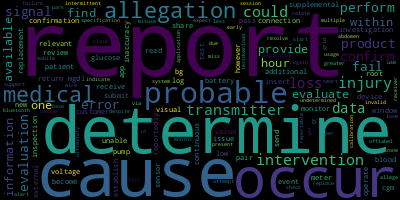

In [14]:
# Import the wordcloud library
from wordcloud import WordCloud

wordcloud_target = {dictionary[i]: freq for i, freq in dictionary.dfs.items()}

# Create a WordCloud object
wordcloud = WordCloud(
    background_color="white", 
    max_words=5000, 
    contour_width=3, 
    contour_color='steelblue', 
    width=1920, 
    height=1080)

# Generate a word cloud
wordcloud = WordCloud().generate_from_frequencies(wordcloud_target)

# Visualize the word cloud
wordcloud.to_image()

In [15]:
# Building LDA model with varying number of topics
min_topics = 2
max_topics = 50
step_size = 1

coherence_scores = []
lda_model_collection = []
coherence_model_collection = []

for num_topics in range(min_topics, max_topics+step_size, step_size):

    lda_model_collection.append(gensim.models.LdaModel(
        bow_corpus, 
        num_topics=num_topics,
        random_state=random_state, 
        id2word=dictionary, 
        passes=10
    ))
    
    coherence_model_collection.append(CoherenceModel(
        model=lda_model_collection[num_topics-2], 
        texts=processed_docs, 
        dictionary=dictionary, 
        coherence='c_v'
    ))
        
    coherence_scores.append(coherence_model_collection[num_topics-2].get_coherence())
    
    print(f"Number of topics: {num_topics}, Coherence Score: {coherence_scores[num_topics-2]}")

# Creating DataFrame of number of topics and corresponding coherence score
coherence_scores_df = pd.DataFrame(
    {'num_topics': range(min_topics, max_topics+step_size, step_size), 
     'coherence_score': coherence_scores}
)

Number of topics: 2, Coherence Score: 0.3338233793196974
Number of topics: 3, Coherence Score: 0.3542728494453635
Number of topics: 4, Coherence Score: 0.3507333179482937
Number of topics: 5, Coherence Score: 0.36121885369303286
Number of topics: 6, Coherence Score: 0.37307530232143654
Number of topics: 7, Coherence Score: 0.33215496352751767
Number of topics: 8, Coherence Score: 0.3789910049695928
Number of topics: 9, Coherence Score: 0.33844756753534067
Number of topics: 10, Coherence Score: 0.3980544691314517
Number of topics: 11, Coherence Score: 0.3889276428827733
Number of topics: 12, Coherence Score: 0.37807327144425257
Number of topics: 13, Coherence Score: 0.3778048319656361
Number of topics: 14, Coherence Score: 0.3836013870178309
Number of topics: 15, Coherence Score: 0.3759400997144853
Number of topics: 16, Coherence Score: 0.39340799790338044
Number of topics: 17, Coherence Score: 0.37435440259221103
Number of topics: 18, Coherence Score: 0.39158379109617353
Number of topi

In [16]:
coherence_scores_df 

,num_topics,coherence_score
0,2,0.333823
1,3,0.354273
2,4,0.350733
3,5,0.361219
4,6,0.373075
5,7,0.332155
6,8,0.378991
7,9,0.338448
8,10,0.398054
9,11,0.388928


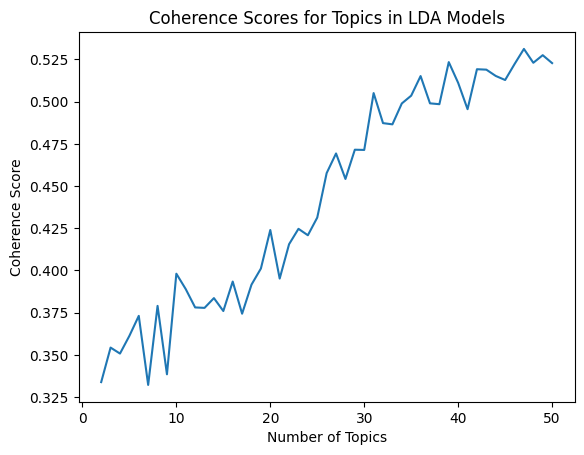

In [17]:
# Plotting the coherence score for each number of topics
x = range(min_topics, max_topics+step_size, step_size)
plt.plot(x, coherence_scores)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title('Coherence Scores for Topics in LDA Models')
plt.show()

In [26]:
# coherence_scores_df is the coherence score dataframe
max_num_topics = coherence_scores_df["coherence_score"].idxmax()

# print the value of num_topics with the highest coherence score
print("num_topics with highest coherence score: ", max_num_topics)

num_topics with highest coherence score:  45


# Analysis with max_num_topics

In [19]:
# Choose the optimal number of topics
num_topics = max_num_topics

# Use the desired models from their respective collections
# "min_topics = 2" so the first model in the collection is 0
# the target model will be located in slot "num_topics - 2"
lda_model = lda_model_collection[num_topics - 2]

coherence_model_lda = coherence_model_collection[num_topics - 2]

coherence_lda = coherence_model_lda.get_coherence()

# Save the LDA model as a pickle file
with open(f"{working_directory}/lda_model_{num_topics}_topics.pickle", "wb") as f:
    pickle.dump(lda_model, f)

# Extract the top 10 words for each topic
top_words = lda_model.print_topics(num_topics=num_topics, num_words=10)

In [20]:
top_words

[(0,
  '0.229*"receiver" + 0.174*"report" + 0.133*"upon" + 0.129*"follow" + 0.127*"completion" + 0.122*"submit" + 0.034*"charge" + 0.033*"boot" + 0.000*"inspect" + 0.000*"adhesive"'),
 (1,
  '0.250*"medical" + 0.250*"intervention" + 0.250*"injury" + 0.250*"report" + 0.000*"fda" + 0.000*"doc" + 0.000*"problem" + 0.000*"power" + 0.000*"stick" + 0.000*"via"'),
 (2,
  '0.343*"confirm" + 0.340*"allegation" + 0.160*"data" + 0.156*"evaluate" + 0.000*"get" + 0.000*"recall" + 0.000*"fda" + 0.000*"power" + 0.000*"via" + 0.000*"experience"'),
 (3,
  '0.129*"transmitter" + 0.128*"report" + 0.114*"error" + 0.103*"fail" + 0.079*"receive" + 0.078*"customer" + 0.067*"base" + 0.066*"reportable" + 0.063*"find" + 0.057*"event"'),
 (4,
  '0.138*"lose" + 0.126*"pump" + 0.125*"connection" + 0.123*"transmitter" + 0.118*"report" + 0.107*"greater" + 0.105*"hour" + 0.078*"via" + 0.074*"data" + 0.002*"doc"'),
 (5,
  '0.206*"cause" + 0.206*"probable" + 0.206*"determine" + 0.202*"could" + 0.097*"allegation" + 0.08

In [21]:
topics_with_scores_df = pd.DataFrame()

for idx, topic in lda_model.show_topics(num_topics=num_topics, num_words=10, formatted=False):
    # creating a list of tuples containing the top 10 words and their probabilities for the topic
    top_words = [(word, round(prob, 4)) for word, prob in topic]
    
    # create a new dictionary to store the topic number and the top words with their probabilities
    row_dict = {'Topic': str(int(idx+1))}
    
    for i, (word, prob) in enumerate(top_words):
        row_dict[f"Word {i+1}"] = word
        row_dict[f"Weight {i+1}"] = str(round(prob, 4))

    # adding the topic and top words to the dataframe
    topics_with_scores_df = topics_with_scores_df.append(row_dict, ignore_index=True)
    
topics_with_scores_df.to_pickle(f"{working_directory}/lda_topics_with_scores_df_{num_topics}_topics.pickle")
topics_with_scores_df.to_csv(f"{working_directory}/lda_topics_with_scores_df_{num_topics}_topics.csv", index=False)

with pd.option_context('display.max_colwidth', None):
    display(topics_with_scores_df)

,Topic,Word 1,Weight 1,Word 2,Weight 2,Word 3,Weight 3,Word 4,Weight 4,Word 5,...,Word 6,Weight 6,Word 7,Weight 7,Word 8,Weight 8,Word 9,Weight 9,Word 10,Weight 10
0,1,receiver,0.229,report,0.1738,upon,0.1326,follow,0.1295,completion,...,submit,0.1219,charge,0.0341,boot,0.033,inspect,1e-04,adhesive,1e-04
1,2,medical,0.2502,intervention,0.2498,injury,0.2498,report,0.2497,fda,...,doc,0.0,problem,0.0,power,0.0,stick,0.0,via,0.0
2,3,confirm,0.3429,allegation,0.3401,data,0.1595,evaluate,0.1561,get,...,recall,0.0,fda,0.0,power,0.0,via,0.0,experience,0.0
3,4,transmitter,0.1291,report,0.1285,error,0.1141,fail,0.1034,receive,...,customer,0.078,base,0.0671,reportable,0.0655,find,0.0627,event,0.0572
4,5,lose,0.1379,pump,0.1261,connection,0.1255,transmitter,0.1232,report,...,greater,0.1071,hour,0.1051,via,0.0776,data,0.0737,doc,0.0018
5,6,cause,0.2059,probable,0.2057,determine,0.2055,could,0.2015,allegation,...,confirmation,0.0835,buttocks,0.0009,inaccuracies,0.0,difference,0.0,power,0.0
6,7,fail,0.2081,error,0.2069,transmitter,0.2019,report,0.1897,occur,...,shutdown,0.0038,doc,0.0,inaccuracies,0.0,fda,0.0,via,0.0
7,8,perform,0.2455,voltage,0.2207,test,0.1541,pass,0.1473,fail,...,check,0.0626,transmitter,0.0389,vdc,0.0102,take,0.0061,fda,0.0
8,9,patient,0.2074,additional,0.2007,information,0.2005,available,0.1972,event,...,problem,0.0,experience,0.0,stick,0.0,difference,0.0,power,0.0
9,10,sensor,0.2109,wire,0.1895,report,0.1818,occur,0.1761,miss,...,skin,0.0613,reaction,0.0226,scar,0.0198,due,0.0,inspect,0.0


Topic 0:


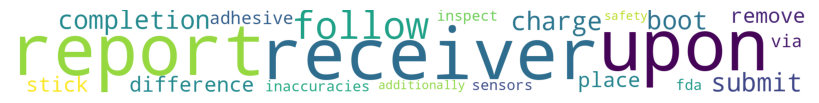

------------------------------
Topic 1:


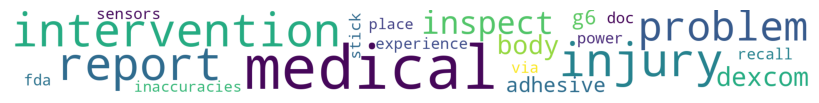

------------------------------
Topic 2:


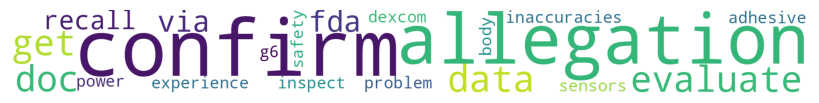

------------------------------
Topic 3:


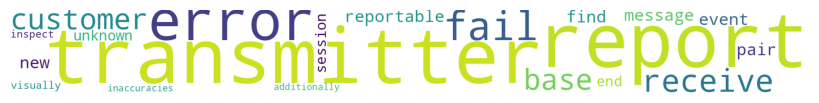

------------------------------
Topic 4:


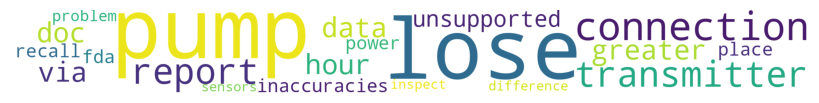

------------------------------
Topic 5:


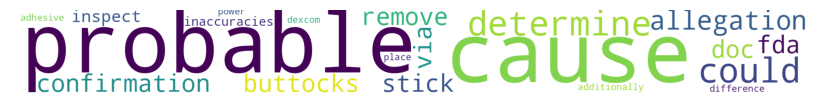

------------------------------
Topic 6:


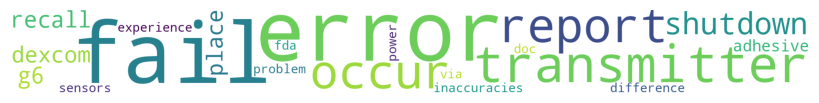

------------------------------
Topic 7:


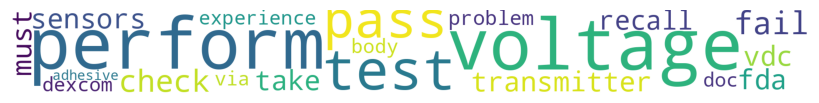

------------------------------
Topic 8:


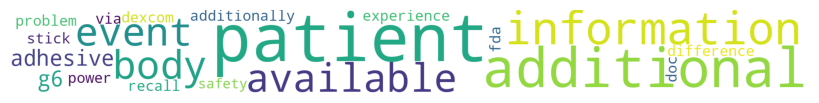

------------------------------
Topic 9:


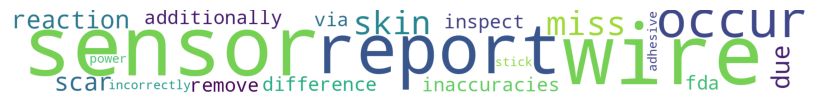

------------------------------
Topic 10:


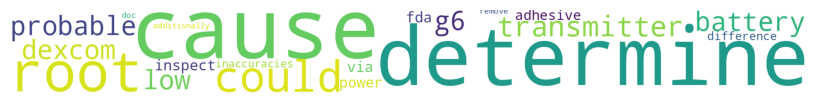

------------------------------
Topic 11:


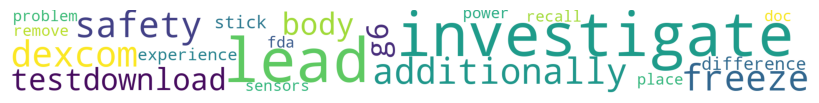

------------------------------
Topic 12:


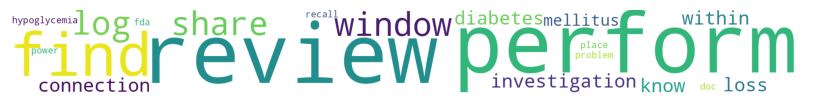

------------------------------
Topic 13:


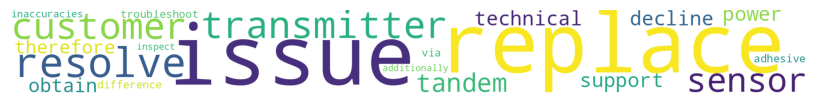

------------------------------
Topic 14:


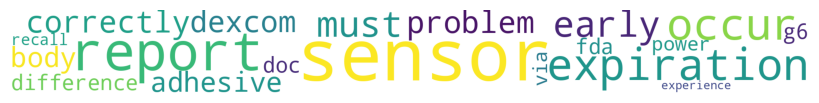

------------------------------
Topic 15:


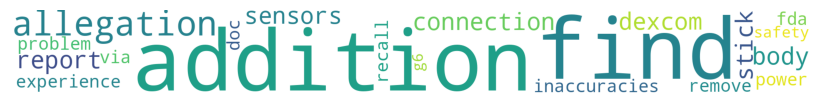

------------------------------
Topic 16:


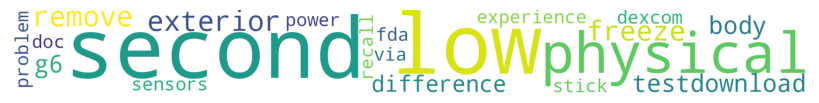

------------------------------
Topic 17:


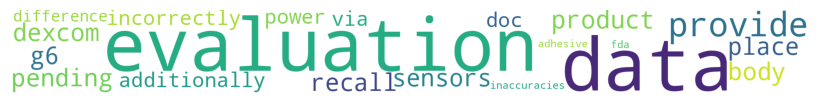

------------------------------
Topic 18:


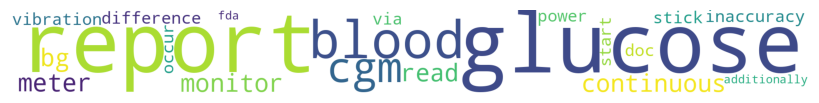

------------------------------
Topic 19:


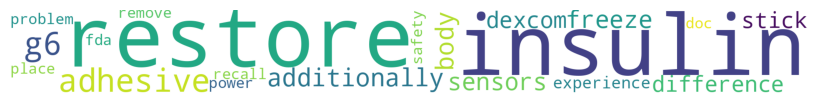

------------------------------
Topic 20:


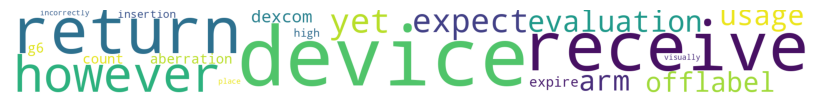

------------------------------
Topic 21:


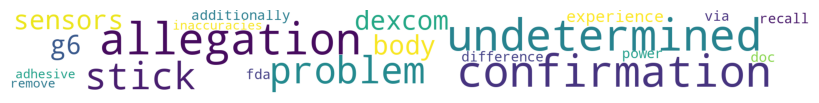

------------------------------
Topic 22:


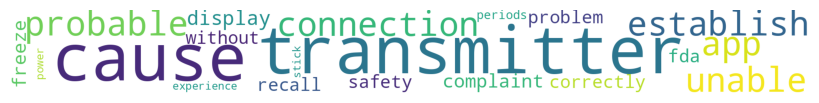

------------------------------
Topic 23:


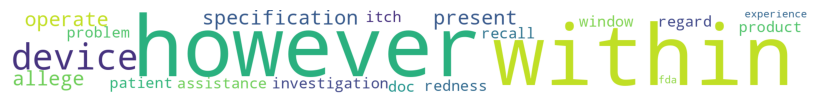

------------------------------
Topic 24:


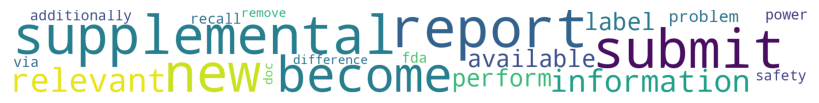

------------------------------
Topic 25:


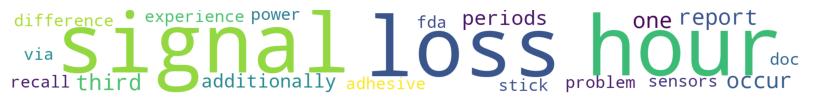

------------------------------
Topic 26:


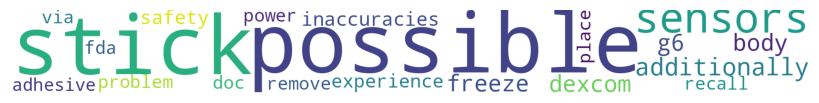

------------------------------
Topic 27:


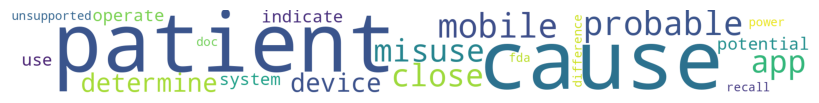

------------------------------
Topic 28:


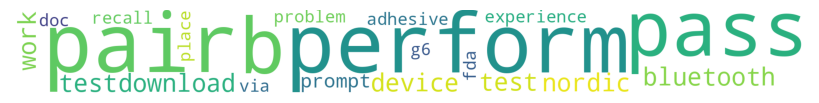

------------------------------
Topic 29:


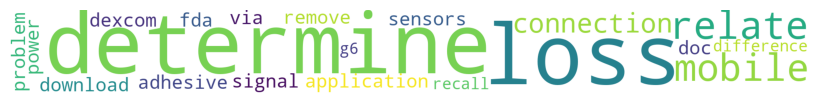

------------------------------
Topic 30:


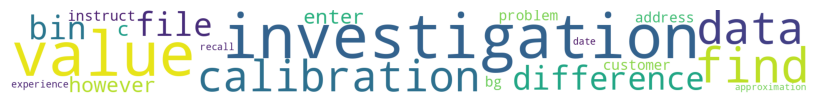

------------------------------
Topic 31:


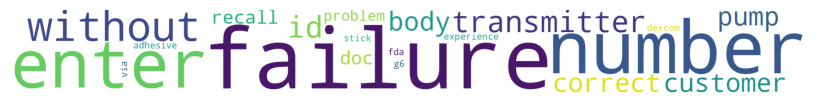

------------------------------
Topic 32:


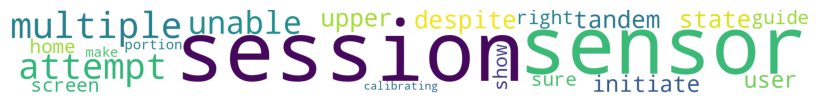

------------------------------
Topic 33:


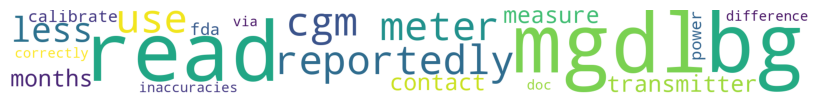

------------------------------
Topic 34:


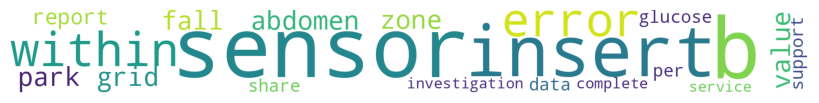

------------------------------
Topic 35:


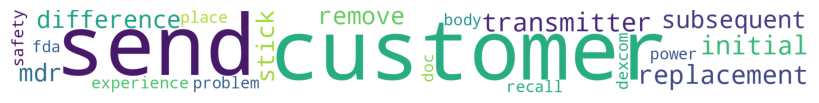

------------------------------
Topic 36:


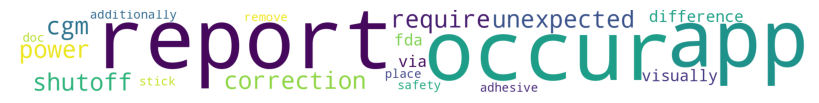

------------------------------
Topic 37:


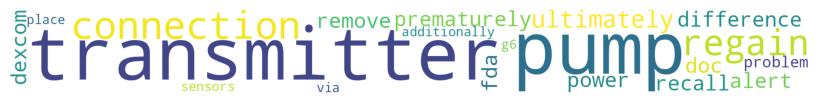

------------------------------
Topic 38:


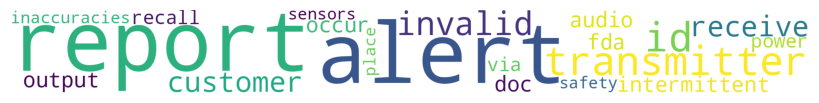

------------------------------
Topic 39:


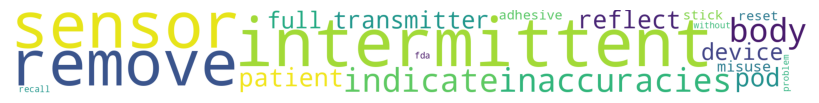

------------------------------
Topic 40:


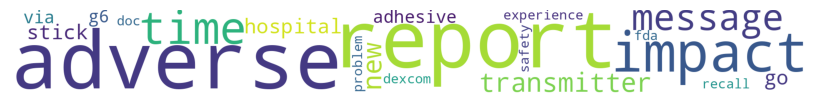

------------------------------
Topic 41:


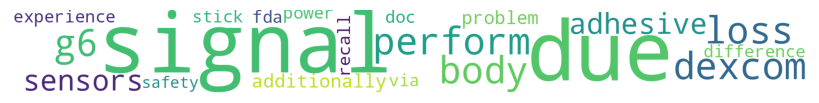

------------------------------
Topic 42:


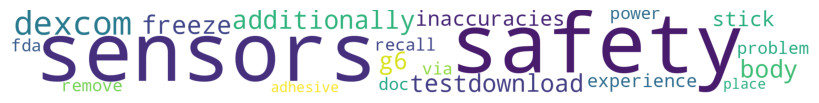

------------------------------
Topic 43:


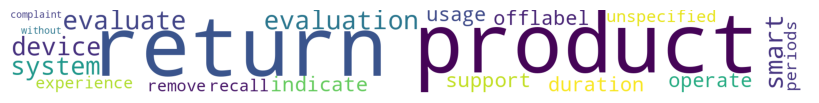

------------------------------
Topic 44:


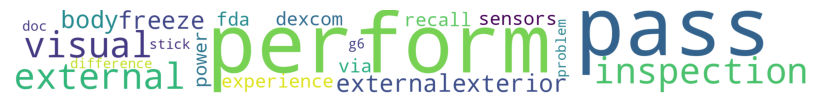

------------------------------


In [25]:
# Generating word clouds for each topic and visualizing 
topics = lda_model.show_topics(num_topics=num_topics, num_words=20)
for topic in topics:
    print(f"Topic {topic[0+]}:")
    wordcloud = WordCloud(width = 1920, 
                background_color ='white', 
                stopwords = stop_words, 
                min_font_size = 10).generate(topic[1])
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()
    print("-" * 30)